# Monte Carlo Methods

En este laboratorio vamos a explorar los métodos de Monte Carlo (Capítulo 5 del libro de Sutton y Barto). Para esto, vamos a volver a utilizar un ambiente definido en OpenAi gym (https://gym.openai.com/), es el caso esta vez de otro ambitente sencillo: el juego de Blackjack. El ambitente esta inspirado por el ejemplo 5.1 del libro, ya esta incluido en gym, por no que no es necesario crearlo desde cero. 

***
### Juego de Blackjack

Es un juego de cartas donde el objetivo es obtener cartas que sumen lo más cercano a 21 posible, sin pasarnos. Jugamos contra un dealer fijo unicamente.

Reglas:
   
- Las cartas con figuras (Jotas, Reinas y Reyes) tienen valor de 10.
- Los Ases pueden valer 11 ó 1, cuando vale 11 se lo llama "usable".
- En este caso jugamos con un mazo infinito (con reemplazo).
- El dealer comienza con una carta boca arriba y una boca abajo.
- El jugador puede pedir una carta (HIT) hasta que decida quedarse (STICK) o exceeda los 21 puntos (BUST).
- Cuando el jugador de queda (STICK), el dealer muestra su carta boca abajo y pide cartas hasta que su suma sea 17 o más.
- Si el dealer se pasa de 21, el jugador gana. En caso contrario, gana quien tenga la suma más cerca de 21.

Ambiente:
- La reward por perder es -1, por ganar es +1 y por pedir carta es 0.
- Cada observacion es una tupla que tiene: 
    - la suma del jugador
    - la carta boca arriba del dealer (1-10 donde 1 es un As)
    - True o False si el jugador tiene un As usable o no

***

### A entregar:

- Notebook con solución a los algoritmos presentados (hecho en clase)
- Analisis de la funcion de valor estimada para distinto número de episodios a visitar (ej: 100, 1000, 10000, 50000). Se busca que puedan demostrar entendimiento del algoritmo y sus resultados (Esperamos gráficas y analisis de las mismas). 
- Estimaciones de funcion de valor para otras dos politicas definidas por el estudiante. 

In [1]:
# Imports necesarios
import gym
import numpy as np
from collections import defaultdict

# Creacion del ambiente
env = gym.make('Blackjack-v0')

# Acciones: 0 = Stick, 1 = HIT
print(env.observation_space)


obs = env.reset()

print(f"Jugador: {obs[0]}, Dealer: {obs[1]}, As usable: {obs[2]} ")


nueva_obs, reward, done, _ = env.step(0)

print(f"Nuevo estado: {nueva_obs}, Recompensa: {reward}, Estado Final: {done}")

Tuple(Discrete(32), Discrete(11), Discrete(2))
Jugador: 13, Dealer: 9, As usable: False 
Nuevo estado: (13, 9, False), Recompensa: -1.0, Estado Final: True


## El algoritmo que vamos a implementar

Vamos a comenzar con el algoritmo 5.1 del libro: `First Visit MC prediction` para estimar la función de valor de una política arbitraria. 

![Image](https://marcinbogdanski.github.io/rl-sketchpad/RL_An_Introduction_2018/assets/0501_FV_MC_Pred.png)

En este caso vamos a querer evaluar una politica que se queda si el jugador tiene un valor mayor o igual a 19, y pide cartas en caso contrario. 



In [2]:
STICK = 0
HIT = 1
import random

def sample_policy(observation):
    """
    Sample policy
    
    PARAM:
    
    observation: Black Jack observation
    """
    return HIT if observation[0] < 19 else STICK

def random_policy(observation):
    """
    Random policy    

    PARAM:
    
    observation: Black Jack observation
    """
    return random.choice([HIT, STICK])

def construct_optimal_policy(calculated_policy, default_f):
    """
    Construct an optimized policy function from a policy data
    dictionary

    PARAM:
    
    calculated_policy: policy data
    default_f: function to execute if the state is not in the policy data
    """
    def f(observation):
        action = calculated_policy.get(observation)
        return action if action else default_f(observation)
    return f


In [3]:
## Generar Episodio 

def generate_episode(environment, policy, epsilon=0):
    """
    Given a policy and an environment it generates an episode
    
    PARAM:
    
    environment
    policy
    epsilon: if set the policy will play epsilon-greedy intead of greedy
    """
    #Colecciones para registrar el episodio 
    states, actions, rewards = [] , [], []
    observation = environment.reset() 
    done = False 
    while not done:
        states.append(observation)
        if np.random.uniform() < epsilon:
            action = random.choice([HIT, STICK])
        else:
            action = policy(observation)
        actions.append(action)
        observation, reward, done, _ = environment.step(action)
        rewards.append(reward)
    return states, actions, rewards

In [4]:
## Algoritmo 
def first_visit_mc_prediction(policy, environment, number_episodes, gamma =1):
    """
    Estimates the environment value given a policy an environment and a number of episodes
    """
    V = defaultdict(float)
    returns = defaultdict(list)
    for episode in range(number_episodes):
        states, actions, rewards = generate_episode(environment, policy)
        G = 0
        #range recibe (comienzo, fin, paso) 
        for t in range(len(actions)-1, -1, -1):
            R = rewards[t]
            G = gamma * G + R
            current_state = states[t]
            if current_state not in states[:t]:
                returns[current_state].append(G)
                V[current_state] = np.mean(returns[current_state])
    return V


def first_visit_mc_policy_control(policy, environment, number_episodes, gamma=1, epsilon=0.1):
    """
    Given a policy, the environment and a number of episodes
    it estimates Q and returns the V* and the best policy from that data
    """
    V = defaultdict(lambda : defaultdict(float))
    returns = defaultdict(lambda: defaultdict(list))
    for episode in range(number_episodes):
        states, actions, rewards = generate_episode(environment, policy, epsilon=epsilon)
        G = 0
        #range recibe (comienzo, fin, paso) 
        for t in range(len(actions)-1, -1, -1):
            R = rewards[t]
            G = gamma * G + R
            current_state = states[t]
            current_action = actions[t]
            if (current_state, current_action) not in zip(states[:t], actions[:t]):
                returns[current_state][current_action].append(G)
                V[current_state][current_action] = np.mean(returns[current_state][current_action])
    V_star = defaultdict(float)
    policy = {}
    for state in V.keys():
        actions, values = zip(*V[state].items())
        V_max = np.max(values)
        best_action = actions[np.argmax(values, axis=0)]
        V_star[state] = V_max
        policy[state] = best_action
    return V_star, policy

In [5]:
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plot_value_distribution(value):
    min_x = min(k[0] for k in value.keys())
    max_x = max(k[0] for k in value.keys())
    min_y = min(k[1] for k in value.keys())
    max_y = max(k[1] for k in value.keys())

    player_sum = np.arange(min_x, max_x + 1)
    dealer_show = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(player_sum, dealer_show)

    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_show), len(usable_ace)))
    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = value[player, dealer, ace]
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    plt.title("Distribucion de valores / sin As usable")
    plt.xlabel("Suma jugador")
    plt.ylabel("Suma dealer")
    ax.plot_surface(X, Y, state_values[:, :, 0].T, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    plt.show()

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    plt.title("Distribucion de valores / con As usable")
    plt.xlabel("Suma jugador")
    plt.ylabel("Suma dealer")
    ax.plot_surface(X, Y, state_values[:, :, 1].T, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    plt.show()

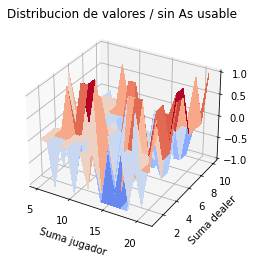

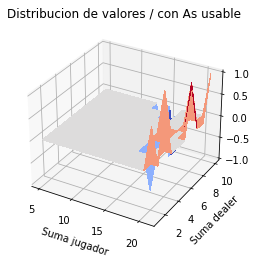

In [6]:
value = first_visit_mc_prediction(sample_policy, env, number_episodes=100)
plot_value_distribution(value)

### Comentarios Sample Policy 100 episodios

En este caso 100 episodios son muy pocos para inferir la dinamica del ambiente, la gráfica es irregular, tenemos casi ningún dato con as usable, lo único que podriamos llegar a ver es que parece que si el jugador tiene casi 20 o entre 5 y 10 gana pero si tiene entre 10 y 15 pierde.

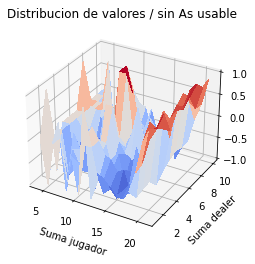

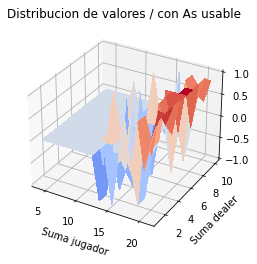

In [7]:
value = first_visit_mc_prediction(sample_policy, env, number_episodes=1000)
plot_value_distribution(value)

### Comentarios Sample Policy 1000 episodios

Tenemos mas episodios por lo cual podemos estimar mejor el ambiente, se confirma un poco lo que veíamos en la gráfica anterior, y cómo tenemos mas datos con as usable: De la gráfica podemos decir que tener un as de 10 a 15 o cerca de 20 es favorable. 

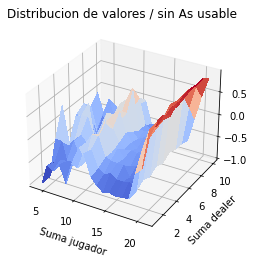

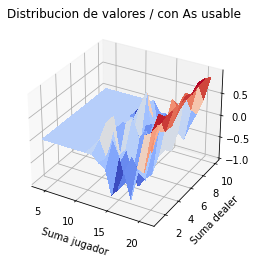

In [8]:
value = first_visit_mc_prediction(sample_policy, env, number_episodes=10000)
plot_value_distribution(value)

### Comentarios Sample Policy 10000 episodios

Contamos con mas episodios, nuestra estimación es mas certera por lo tanto nuestra gráfica tiene menos ruido, se normalizaron los valores extremos, no tenemos más al jugador consiguiendo un retorno de 1, se ajusto la predicción, en el intérvalo 7-10 pasando a ser neutral, ganando en 18-20 y perdiendo en otro caso 

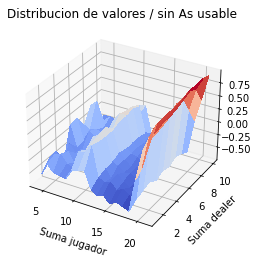

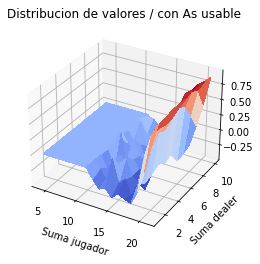

In [9]:
value = first_visit_mc_prediction(sample_policy, env, number_episodes=50000)
plot_value_distribution(value)

### Comentarios Sample Policy 50000 episodios

Al tener mas episodios se normalizaron los extremos bajos, y la grafica perdió ruido, podemos inferir que conseguir un as es algo bueno dado que si tenemos un as nuestro minimo retorno es -0.25 mientras que en otro caso es 0.50

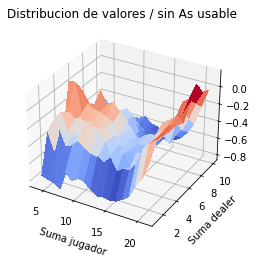

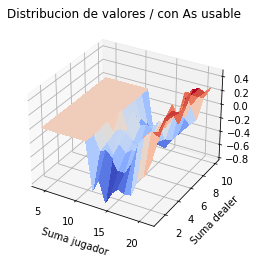

In [10]:
value = first_visit_mc_prediction(random_policy, env, number_episodes=50000)
plot_value_distribution(value)

### Comentarios Random Policy 50000 episodios

La politica random siempre pierde, a lo mejor que puede aspirar es a no perder, probablemente porque pide estando en los valores altos, ganando cuando llega a 21 exactamente y el juego termina forzosamente, o el 50% de chance que tiene de quedarse cuando esta en valores favorables
Escribí esta política como contraste para la sample policy, que funciona bastante bien, y como política inicial de la política optimizada dado que como es aleatoria explora mucho.

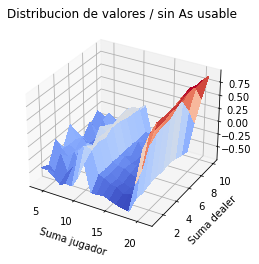

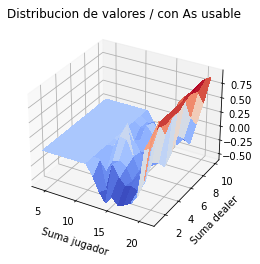

In [11]:
_, policy_data = first_visit_mc_policy_control(random_policy, env, number_episodes=50000)
opt_policy = construct_optimal_policy(policy_data, sample_policy)
value = first_visit_mc_prediction(opt_policy, env, number_episodes=50000)
plot_value_distribution(value)

### Comentarios Optimized policy 50000 episodios
Implementé la optimización de política, utilizé la política aleatoria de base y apliqué el algoritmo para 50.000 casos, obtuve una optimización de esa política y luego aplique el algoritmo para estimar nuevamente el valor, la gráfica se parece bastante a la de sample policy, podemos considerar que sample policy era una política bastante buena.